# Hyper parameters

In [153]:
DAYS_FUTURE = 50
DAYS_PAST = 50

HP_UNITS = 100
HP_LAYERS = 3

TRAIN_START = "2015-01-01"
TRAIN_END = "2020-01-01"

TEST_START = "2020-01-01"
TEST_END = "2021-01-01"

HP_DROPOUT = 0.5
HP_LR = 0.001
HP_BATCH_SIZE = 2048
HP_EPOCHS = 340

labels = ['next1', 'next2', 'next3']


In [154]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline


# Get Data

In [155]:
import quandl as q 

In [156]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [157]:
data = q.get('BITFINEX/BTCUSD') 

In [158]:
data

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.900000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774
2014-04-16,547.000000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705
2014-04-17,538.500000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819
2014-04-18,509.000000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243
2014-04-19,513.989900,473.83,505.01065,507.499900,502.5313,507.49,8963.618369
...,...,...,...,...,...,...,...
2021-10-28,62444.000000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417
2021-10-29,62980.000000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450
2021-10-30,62409.000000,60755.00,61407.50000,61408.000000,61407.0000,61408.00,2185.606697


<AxesSubplot:xlabel='Date'>

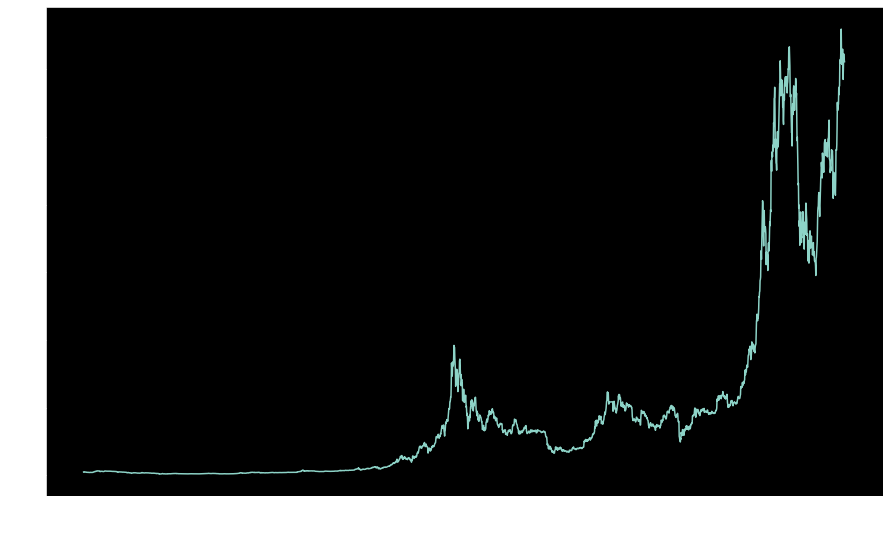

In [159]:
# show candles
data['Last'].plot(figsize=(15, 10))


# Create features

In [160]:
for i in range(1, DAYS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [161]:
for i in range(1, DAYS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [162]:
data

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-15,513.900000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774,NaN,NaN,NaN,...,-0.133630,-0.126886,-0.125419,-0.213369,-0.213193,-0.246241,-0.275153,-0.244692,-0.271764,-0.256253
2014-04-16,547.000000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705,0.063300,NaN,NaN,...,-0.063585,-0.062119,-0.150069,-0.149893,-0.182941,-0.211853,-0.181392,-0.208464,-0.192953,-0.199369
2014-04-17,538.500000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819,-0.057377,0.005923,NaN,...,-0.119496,-0.207446,-0.207270,-0.240318,-0.269230,-0.238769,-0.265841,-0.250330,-0.256746,-0.258480
2014-04-18,509.000000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243,-0.050983,-0.108360,-0.045060,...,-0.258429,-0.258253,-0.291301,-0.320213,-0.289751,-0.316823,-0.301312,-0.307728,-0.309463,-0.298227
2014-04-19,513.989900,473.83,505.01065,507.499900,502.5313,507.49,8963.618369,0.049998,-0.000985,-0.058362,...,-0.208255,-0.241303,-0.270215,-0.239754,-0.266826,-0.251315,-0.257731,-0.259465,-0.248229,-0.258401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,62444.000000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417,0.034978,0.007653,-0.038649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-29,62980.000000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450,0.027586,0.062564,0.035239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-30,62409.000000,60755.00,61407.50000,61408.000000,61407.0000,61408.00,2185.606697,-0.014341,0.013245,0.048223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model create

In [163]:
import tensorflow as tf


In [164]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        HP_LR), metrics=["accuracy"])
    return model


# Split to train set and test set

In [165]:
X_train = data.loc[(data.index >= TRAIN_START) &
                   (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) &
                  (data.index <= TEST_END)]


In [166]:
X_test.head()

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7285.1,7185.4,7213.05,7213.1,7213.0,7213.1,2045.343527,0.000319,-0.006701,-0.027728,...,-0.314705,-0.351476,-0.359057,-0.346881,-0.358185,-0.315625,-0.325686,-0.294679,-0.345261,-0.287290
2020-01-02,7225.8,6963.0,6989.45,6989.5,6989.4,6989.5,4848.085330,-0.031490,-0.031171,-0.038191,...,-0.382966,-0.390546,-0.378371,-0.389675,-0.347115,-0.357176,-0.326169,-0.376750,-0.318780,-0.318225
2020-01-03,7444.9,6909.3,7356.95,7356.9,7356.9,7357.0,6653.414357,0.051230,0.019740,0.020059,...,-0.339317,-0.327141,-0.338445,-0.295885,-0.305946,-0.274940,-0.325521,-0.267551,-0.266995,-0.276487
2020-01-04,7422.0,7297.3,7373.05,7373.0,7373.0,7373.1,4264.090728,0.002186,0.053416,0.021926,...,-0.324955,-0.336259,-0.293699,-0.303760,-0.272754,-0.323335,-0.265364,-0.264809,-0.274301,-0.270241
2020-01-05,7509.9,7315.8,7346.65,7344.9,7346.6,7346.7,4415.509410,-0.003818,-0.001632,0.049597,...,-0.340078,-0.297518,-0.307578,-0.276572,-0.327153,-0.269183,-0.268628,-0.278120,-0.274060,-0.306857


In [167]:

y_train = X_train[labels].to_numpy()  # X - source, y - target
y_test = X_test[labels].to_numpy()


In [168]:
columns = []
for i in range(1, DAYS_PAST):
    columns.append('prev' + str(i))


In [169]:
X_train = X_train[columns].to_numpy()
X_test = X_test[columns].to_numpy()


In [170]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)


In [171]:
model = create_model(X_test.shape, len(y_test[0]))


# Training model

In [172]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=HP_BATCH_SIZE,
    # callbacks=[callback_early],
    verbose=1, epochs=HP_EPOCHS)


Epoch 1/340
1/1 [==============================] - 1s 790ms/step - loss: 0.0353 - accuracy: 0.3982 - val_loss: 0.0039 - val_accuracy: 0.4044
Epoch 2/340
1/1 [==============================] - 0s 28ms/step - loss: 0.0234 - accuracy: 0.3876 - val_loss: 0.0031 - val_accuracy: 0.3415
Epoch 3/340
1/1 [==============================] - 0s 29ms/step - loss: 0.0146 - accuracy: 0.3356 - val_loss: 0.0032 - val_accuracy: 0.2705
Epoch 4/340
1/1 [==============================] - 0s 34ms/step - loss: 0.0118 - accuracy: 0.3507 - val_loss: 0.0034 - val_accuracy: 0.2623
Epoch 5/340
1/1 [==============================] - 0s 40ms/step - loss: 0.0095 - accuracy: 0.3266 - val_loss: 0.0035 - val_accuracy: 0.2760
Epoch 6/340
1/1 [==============================] - 0s 40ms/step - loss: 0.0079 - accuracy: 0.3266 - val_loss: 0.0034 - val_accuracy: 0.2842
Epoch 7/340
1/1 [==============================] - 0s 45ms/step - loss: 0.0069 - accuracy: 0.3054 - val_loss: 0.0033 - val_accuracy: 0.2869
Epoch 8/340
1/1 [==

In [173]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [174]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


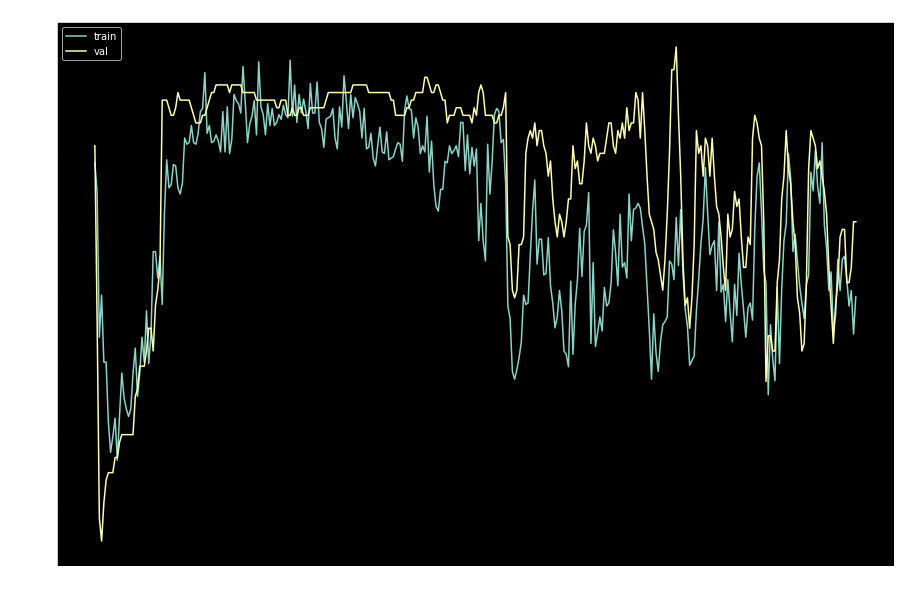

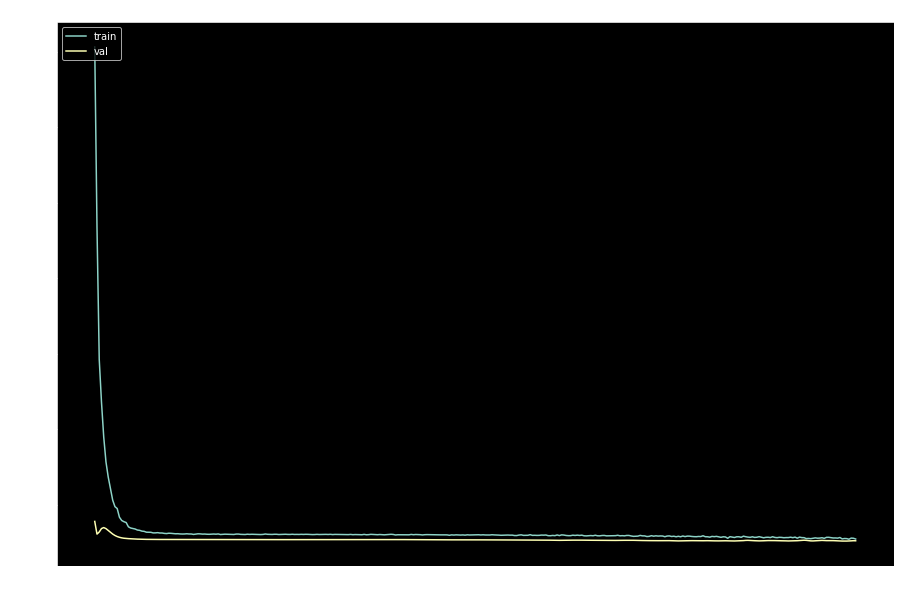

In [175]:
plt.figure(figsize=(15, 10))
plot_accuracy(history)
plt.figure(figsize=(15, 10))
plot_loss(history)


# Trains results

In [176]:
train_prediction=model.predict(X_train)

<AxesSubplot:ylabel='Count'>

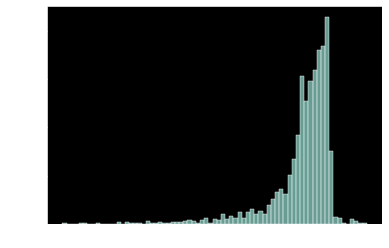

In [177]:
import seaborn as sns

sns.histplot(data=train_prediction[:, 2])


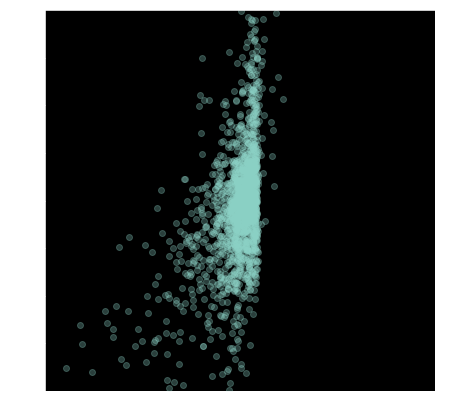

In [178]:
# scattered plot
plt.figure(figsize=(7, 7))
plt.xlim(-0.1, 0.1)
plt.ylim(-0.2, 0.2)
plt.scatter(train_prediction[:, 2], y_train[:, 2], alpha=0.3)


# Test results

In [179]:
test_prediction=model.predict(X_test)

<AxesSubplot:ylabel='Count'>

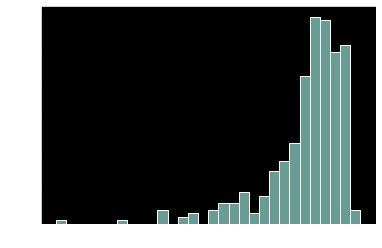

In [180]:
import seaborn as sns

sns.histplot(data=test_prediction[:, 2])


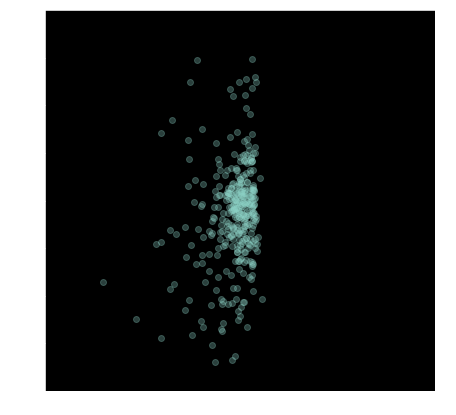

In [181]:
# scattered plot
plt.figure(figsize=(7, 7))
plt.xlim(-0.1, 0.1)
plt.ylim(-0.2, 0.2)
plt.scatter(test_prediction[:, 2], y_test[:, 2], alpha=0.3)
